In [1]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
from functools import partial
from multiprocessing import Pool
import sncosmo
%matplotlib nbagg

from astropy.table import Column
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
dataset='spcc'
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

read_from_file=False #True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'%s_all' %dataset)
rt=os.path.join('SPCC_SUBSET','')


Neural networks not available in this version of scikit-learn. Neural networks are available from development version 0.18.


In [2]:
def make_new_data(filename, table, output, sntype):
    with open(filename) as f:
        data = f.read().split("\n")
    filters = data[5].split()
    survey = data[0].split()
    stuffRA = data[6].split()
    stuffDec = data[7].split()
    MWEBV = data[11].split()
    if sntype==1:
        typestring='SN Type = Ia , MODEL = mlcs2k2.SNchallenge'
    elif sntype==2:
        typestring='SN Type = II , MODEL = SDSS-017564'
    elif sntype==3:
        typestring='SN Type = Ic , MODEL = SDSS-014475'
    else:
        typestring='SOMETHING WENT HORRIBLY WRONG'
    table.meta = {survey[0][:-1]: survey[1], stuffRA[0][:-1]: stuffRA[1], stuffDec[0][:-1]: stuffDec[1],filters[0][:-1]: filters[1],
                 MWEBV[0][:-1]: MWEBV[1], 'SNTYPE': -9, 'SIM_COMMENT': typestring  }
    #table.rename_column('mjd', 'MJD')
    #table.rename_column('filter ', 'FLT')
    #table.rename_column('flux', 'FLUXCAL')
    #table.rename_column('flux_error', 'FLUXCALERR')
    sncosmo.write_lc(table, 'new_mocks/%s'%output,pedantic=True, format = 'snana')

In [3]:
prototypes_Ia=[ 'DES_SN002542.DAT', 'DES_SN013866.DAT', 'DES_SN023940.DAT', 'DES_SN024734.DAT', 'DES_SN030701.DAT', 'DES_SN045040.DAT']
prototypes_II=[ 'DES_SN002457.DAT', 'DES_SN005519.DAT', 'DES_SN006381.DAT', 'DES_SN008569.DAT', 'DES_SN013360.DAT', 'DES_SN013481.DAT']
prototypes_Ibc=['DES_SN005399.DAT', 'DES_SN013863.DAT', 'DES_SN027266.DAT', 'DES_SN030183.DAT', 'DES_SN065493.DAT', 'DES_SN078241.DAT']
len(prototypes_II)

6

In [4]:
prototypes_II

['DES_SN002457.DAT',
 'DES_SN005519.DAT',
 'DES_SN006381.DAT',
 'DES_SN008569.DAT',
 'DES_SN013360.DAT',
 'DES_SN013481.DAT']

In [5]:
def produce_mock_data_set(degrading_factor, realsperlc=100, prototypes_Ia=['DES_SN002542.DAT'], prototypes_II=['DES_SN002457.DAT'], prototypes_Ibc=['DES_SN005399.DAT']):
    #Data root
    dat=sndata.Dataset(rt)

    types=dat.get_types()
    types['Type'][np.floor(types['Type']/10)==2]=2
    types['Type'][np.floor(types['Type']/10)==3]=3
                             
    logfile=open('new_mocks/new_mocks.LIST', 'w')
    
    for prot in range(len(prototypes_II)):
        type_II = []
        for i in range(len(dat.data[prototypes_II[prot]]['flux'])):
            type_II.append(np.random.normal(dat.data[prototypes_II[prot]]['flux'][i], dat.data[prototypes_II[prot]]['flux_error'][i]*degrading_factor, realsperlc))
        type_II = np.array(type_II)
        filename_II = 'SPCC_SUBSET/'+prototypes_II[prot]
        test_table_II = dat.data[prototypes_II[prot]]
        test_table_II.rename_column('flux', 'FLUXCAL')
        test_table_II.rename_column('flux_error', 'FLUXCALERR')
        col_II = Table.Column(name='field',data=np.zeros(len(test_table_II)) )
        test_table_II.add_column(col_II, index = 2)
        for i in range(realsperlc):
            test_table_II.replace_column('FLUXCAL', type_II[:,i])
            test_table_II.replace_column('FLUXCALERR', test_table_II['FLUXCALERR']*degrading_factor)
            make_new_data(filename_II, test_table_II, 'II_%s_%s'%(i,prototypes_II[prot]), 2)
            logfile.write('II_'+str(i)+'_'+prototypes_II[prot]+'\n')

    for prot in range(len(prototypes_Ia)):
        type_Ia = []
        for i in range(len(dat.data[prototypes_Ia[prot]]['flux'])):
            type_Ia.append(np.random.normal(dat.data[prototypes_Ia[prot]]['flux'][i], dat.data[prototypes_Ia[prot]]['flux_error'][i]*degrading_factor, realsperlc))
        type_Ia = np.array(type_Ia)
        filename_Ia = 'SPCC_SUBSET/'+prototypes_Ia[prot]
        test_table_Ia = dat.data[prototypes_Ia[prot]]
        test_table_Ia.rename_column('flux', 'FLUXCAL')
        test_table_Ia.rename_column('flux_error', 'FLUXCALERR')
        col_Ia = Table.Column(name='field',data=np.zeros(len(test_table_Ia)) )
        test_table_Ia.add_column(col_Ia, index = 2)
        for i in range(realsperlc):
            test_table_Ia.replace_column('FLUXCAL', type_Ia[:,i])
            test_table_Ia.replace_column('FLUXCALERR', test_table_Ia['FLUXCALERR']*degrading_factor)
            make_new_data(filename_Ia, test_table_Ia, 'Ia_%s_%s'%(i,prototypes_Ia[prot]), 1)
            logfile.write('Ia_'+str(i)+'_'+prototypes_Ia[prot]+'\n')
        
    for prot in range(len(prototypes_Ibc)):
        type_Ibc = []
        for i in range(len(dat.data[prototypes_Ibc[prot]]['flux'])):
            type_Ibc.append(np.random.normal(dat.data[prototypes_Ibc[prot]]['flux'][i], dat.data[prototypes_Ibc[prot]]['flux_error'][i]*degrading_factor, realsperlc))
        type_Ibc = np.array(type_Ibc)
        filename_Ibc = 'SPCC_SUBSET/'+prototypes_Ibc[prot]
        test_table_Ibc = dat.data[prototypes_Ibc[prot]]
        test_table_Ibc.rename_column('flux', 'FLUXCAL')
        test_table_Ibc.rename_column('flux_error', 'FLUXCALERR')
        col_Ibc = Table.Column(name='field',data=np.zeros(len(test_table_Ibc)) )
        test_table_Ibc.add_column(col_Ibc, index = 3)
        for i in range(realsperlc):
            test_table_Ibc.replace_column('FLUXCAL', type_Ibc[:,i])
            test_table_Ibc.replace_column('FLUXCALERR', test_table_Ibc['FLUXCALERR']*degrading_factor)
            make_new_data(filename_Ibc, test_table_Ibc, 'Ibc_%s_%s'%(i,prototypes_Ibc[prot]), 3)
            logfile.write('Ibc_'+str(i)+'_'+prototypes_Ibc[prot]+'\n')

    logfile.close()
    

In [6]:
#produce_mock_data_set(1.1, 111, prototypes_Ia, prototypes_II, prototypes_Ibc)


In [7]:
def AUC_from_mock_data_set(classifiers=['nb','knn','svm','neural_network','boost_dt']):
    rt1=os.path.join('new_mocks','')
    dat1=sndata.Dataset(rt1)
    for obj in dat1.object_names:
        for i in range(len(dat1.data[obj])):
            dat1.data[obj]['filter'][i]=dat1.data[obj]['filter'][i][3:7]
    types=dat1.get_types()
    types['Type'][np.floor(types['Type']/10)==2]=2
    types['Type'][np.floor(types['Type']/10)==3]=3
    %%capture --no-stdout
 
    mod1Feats=snfeatures.ParametricFeatures('karpenka',sampler='leastsq')
    mod1_features=mod1Feats.extract_features(dat1,nprocesses=4,chain_directory=out_int)
    mod1_features.write('%s_karpenka.dat' %run_name, format='ascii')
    #Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
    for c in mod1_features.colnames[1:]:
        mod1_features[c][np.isnan(mod1_features[c])]=0
    mod1Feats.fit_sn
    dat1.set_model(mod1Feats.fit_sn,mod1_features)
    
    AUC=[]
    nprocesses=4
    return_classifier=False
    columns=[]
    training_set=0.7
    param_dict={}
    scale=True
    
    if isinstance(mod1_features,Table):
        #The features are in astropy table format and must be converted to a numpy array before passing to sklearn

        #We need to make sure we match the correct Y values to X values. The safest way to do this is to make types an
        #astropy table as well.

        if not isinstance(types,Table):
            types=Table(data=[mod1_features['Object'],types],names=['Object','Type'])
        feats=join(mod1_features,types,'Object')

        if len(columns)==0:
            columns=feats.columns[1:-1]

        #Split into training and validation sets
        if np.isscalar(training_set):
            objs=feats['Object']
            objs=np.random.permutation(objs)
            training_set=objs[:(int)(training_set*len(objs))]

        #Otherwise a training set has already been provided as a list of Object names and we can continue
        feats_train=feats[np.in1d(feats['Object'],training_set)]
        feats_test=feats[~np.in1d(feats['Object'],training_set)]

        X_train=np.array([feats_train[c] for c in columns]).T
        y_train=np.array(feats_train['Type'])
        X_test=np.array([feats_test[c] for c in columns]).T
        y_test=np.array(feats_test['Type'])

    else:
        #Otherwise the features are already in the form of a numpy array
        if np.isscalar(training_set):
            inds=np.random.permutation(range(len(features)))
            train_inds=inds[:(int)(len(inds)*training_set)]
            test_inds=inds[(int)(len(inds)*training_set):]

        else:
            #We assume the training set has been provided as indices
            train_inds=training_set
            test_inds=range(len(types))[~np.in1d(range(len(types)),training_set)]

        X_train=mod1_features[train_inds]
        y_train=types[train_inds]
        X_test=mod1_features[test_inds]
        y_test=types[test_inds]


    #Rescale the data (highly recommended)
    if scale:
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(np.vstack((X_train, X_test)))
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    probabilities={}
    classifier_objects={}

    if nprocesses>1 and return_classifier:
        print "Due to limitations with python's multiprocessing module, classifier objects cannot be returned if " \
              "multiple processors are used. Continuing serially..."
        print

    if nprocesses>1 and not return_classifier:
        partial_func=partial(snclassifier.__call_classifier,X_train=X_train, y_train=y_train, X_test=X_test,
                             param_dict=param_dict,return_classifier=False)
        p=Pool(nprocesses)
        result=p.map(partial_func,classifiers)

        for i in range(len(result)):
            cls=classifiers[i]
            probabilities[cls]=result[i]

    else:
        for cls in classifiers:
            probs,clf=snclassifier.__call_classifier(cls, X_train, y_train, X_test, param_dict,return_classifier)
            probabilities[cls]=probs
            if return_classifier:
                classifier_objects[cls]=clf

    for i in range(len(classifiers)):
        cls=classifiers[i]
        probs=probabilities[cls]
        fpr, tpr, auc=snclassifier.roc(probs, y_test, true_class=1)
        AUC.append(auc)
    return AUC


In [8]:
classifiers=['nb','svm','boost_dt']
#replace model
#run with full size data set
#put classifier names into plot
auc_allclass={}

for cl in classifiers:
    auc_grid=[]
    for i in range(11):
        produce_mock_data_set(1.+i/10, 11, prototypes_Ia, prototypes_II, prototypes_Ibc)
        auc_grid=np.append(auc_grid, AUC_from_mock_data_set([cl]));
    auc_allclass[cl]=auc_grid

Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in exp
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
   

198 objects fitted
Time taken is 1.94 minutes
Fitting supernova models...


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in exp
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))


Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -2.167985
      logB = -6.035860
        t0 = +99.117269
        t1 = +5.520324
    T_rise = +0.013788
    T_fall = +0.000944

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in multiply
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatur

198 objects fitted
Time taken is 46.79 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -3.770285
      logB = -1.539191
        t0 = +66.449300
        t1 = +4.652588
    T_rise = +0.013901
    T_fall = +0.014994

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -2.973704
      logB = -1.445439
        t0 = +70.059511
        t1 = +65.323590
    T_rise = +0.006619
    T_fall = +0.008739

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = 

198 objects fitted
Time taken is 35.33 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +2.482233
      logB = +0.206593
        t0 = +2.018351
        t1 = +62.157742
    T_rise = +0.000205
    T_fall = +0.001047

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migr

198 objects fitted
Time taken is 35.87 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 32.12 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarnin

198 objects fitted
Time taken is 23.73 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -0.127017
      logB = -5.151161
        t0 = +44.340302
        t1 = +14.969244
    T_rise = +0.000401
    T_fall = +0.039791

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.mig

198 objects fitted
Time taken is 30.64 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following argume

198 objects fitted
Time taken is 36.86 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +1.807234
      logB = -2.639987
        t0 = +25.333518
        t1 = +43.311751
    T_rise = +0.000040
    T_fall = +0.007825

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn

198 objects fitted
Time taken is 34.42 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +3.164121
      logB = +1.072855
        t0 = +55.474349
        t1 = +73.621664
    T_rise = +0.000088
    T_fall = +0.005992

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = 

198 objects fitted
Time taken is 32.00 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in multiply
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew

198 objects fitted
Time taken is 25.36 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
GaussianNB()

Optimised parameters: {}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+n

198 objects fitted
Time taken is 1.74 minutes
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 100000.0, 'gamma': 0.0031622776601683794}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 45.47 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 31.622776601683793, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 35.03 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 31.622776601683793, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarnin

198 objects fitted
Time taken is 30.77 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 31.622776601683793, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snm

198 objects fitted
Time taken is 29.92 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 31.622776601683793, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+n

198 objects fitted
Time taken is 27.41 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 100000.0, 'gamma': 0.0031622776601683794}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following argume

198 objects fitted
Time taken is 23.12 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 1778.2794100389228, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following argume

198 objects fitted
Time taken is 22.87 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 100000.0, 'gamma': 0.0031622776601683794}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following argume

198 objects fitted
Time taken is 21.95 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 1778.2794100389228, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -11.339836
      logB = +4.593899
        t0 = +67.831411
        t1 = +0.907259
    T_rise = +0.003664
    T_fall = +0.003826

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/

198 objects fitted
Time taken is 19.59 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 100000.0, 'gamma': 0.0031622776601683794}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarnin

198 objects fitted
Time taken is 20.39 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimised parameters: {'C': 31.622776601683793, 'gamma': 0.0031622776601683794}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 1.41 minutes
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 35, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in multiply
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +5.940881
      logB = +0.956898
        t0 = +58.322145
        t1 = +22.066325
    T_rise = +0.052536
    T_fall = +0.007515

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
  

198 objects fitted
Time taken is 37.73 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 35, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in multiply
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments

198 objects fitted
Time taken is 31.44 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 25, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarnin

198 objects fitted
Time taken is 32.19 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 45, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -3.210618
      logB = -3.876466
        t0 = +9.136078
        t1 = +3.413181
    T_rise = +0.004149
    T_fall = +0.002315

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -3.210618
      logB = -3.876466
        t0 = +9.136078
        t1 = +3.413181
    T_rise = +0.004149
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarni

198 objects fitted
Time taken is 23.07 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Optimised parameters: {'n_estimators': 35, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +3.913252
      logB = +1.616716
        t0 = +85.819598
        t1 = +65.017052
    T_rise = +0.000030
    T_fall = +0.033865

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn

198 objects fitted
Time taken is 20.92 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 65, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: overflow encountered in multiply
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall =

198 objects fitted
Time taken is 20.60 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 65, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/parametric_models.py:153: RuntimeWarning: invalid value encountered in divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -10.313592
      logB = +3.647974
        t0 = +80.057478
        t1 = +1.351416
    T_rise = +0.108420
    T_fall = +0.108242

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn

198 objects fitted
Time taken is 21.07 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +2.662497
      logB = -5.289170

198 objects fitted
Time taken is 25.87 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 23.06 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


Reading data...
23 objects read into memory.
Reading data...
198 objects read into memory.


/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t0 = +nan
        t1 = +nan
    T_rise = +nan
    T_fall = +nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = -nan
      logB = -nan
        t0 = -nan
        t1 = -nan
    T_rise = -nan
    T_fall = -nan

  m.migrad()
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:138: RuntimeWarning: overflow encountered in multiply
  chi2=np.sum((y-ynew)*(y-ynew)/err/err)
/home/robert/developing/snmachine/snmachine/snfeatures.py:161: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
      logA = +nan
      logB = +nan
        t

198 objects fitted
Time taken is 24.61 seconds
Fitting supernova models...
Models fitted.
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {'n_estimators': 55, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


In [9]:
auc_allclass

{'boost_dt': array([ 0.9987163 ,  0.95171958,  0.91381669,  0.94740741,  0.95299647,
         0.83969907,  0.94749695,  0.96506211,  0.93223443,  0.99005682,
         0.95314506]),
 'nb': array([ 0.9437799 ,  0.95257143,  0.86392811,  0.88766789,  0.74740741,
         0.75738126,  0.72962963,  0.83994528,  0.66914286,  0.60515873,
         0.585     ]),
 'svm': array([ 0.98990683,  0.85943517,  0.88139205,  0.86184211,  0.93589744,
         0.92368742,  0.9623803 ,  0.71142857,  0.83431257,  0.83490012,
         0.88492063])}

<IPython.core.display.Javascript object>


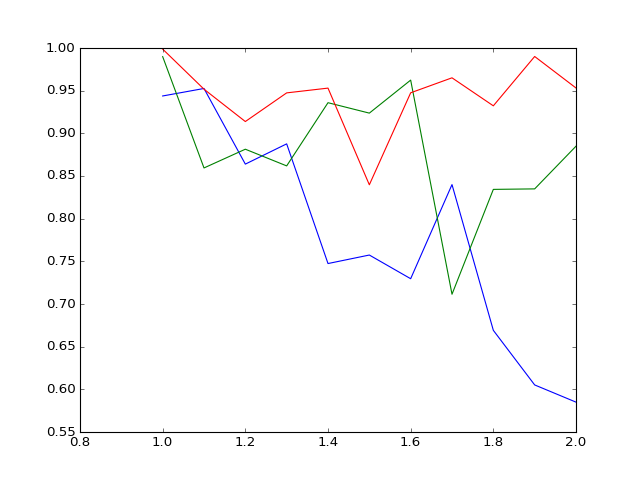

In [10]:
for cl in classifiers:
    plt.plot(np.linspace(1., 2., 11), auc_allclass[cl])
plt.show()

In [ ]:
dat1.plot_all()

In [ ]:
plt.figure()
tsne_plot.plot(mod1_features,join(mod1_features,types)['Type'])

In [ ]:
plt.figure()
clss=snclassifier.run_pipeline(mod1_features,types,output_name=os.path.join(out_class,'model1'),
                          classifiers=['nb','svm','boost_dt'], nprocesses=4)

In [ ]:
np.sort(dat.object_names)

In [ ]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

In [ ]:
#dat.plot_all()

In [ ]:
#wave_features

In [ ]:
#types

In [ ]:
#join(wave_features, types)

In [ ]:
#plt.figure()
#tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

In [ ]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
#dat.set_model(salt2Feats.fit_sn,salt2_features)

In [ ]:
#dat.plot_all()

In [ ]:
#dat.data[dat.object_names[5]]